#ch07-How to Develop a DCGAN for Grayscale Handwritten Digits
- [ch07-How to Develop a DCGAN for Grayscale Handwritten Digits](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-an-mnist-handwritten-digits-from-scratch-in-keras/) by [Jason Brownlee](https://machinelearningmastery.com/author/jasonb/) on Sept 1, 2020 in [Generative Adversarial Networks](https://machinelearningmastery.com/category/generative-adversarial-networks/)
- Customized by Ivan HP Lin (WIP-4)

[Generative Adversarial Networks](https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/), or GANs, are an architecture for training generative models, such as deep convolutional neural networks for generating images.

Developing a GAN for generating images requires both a discriminator convolutional neural network model for classifying whether a given image is real or generated and a generator model that uses inverse convolutional layers to transform an input to a full two-dimensional image of pixel values.

It can be challenging to understand both how GANs work and how deep convolutional neural network models can be trained in a GAN architecture for image generation. A good starting point for beginners is to practice developing and using GANs on standard image datasets used in the field of computer vision, such as the MNIST handwritten digit dataset. Using small and well-understood datasets means that smaller models can be developed and trained quickly, allowing the focus to be put on the model architecture and image generation process itself.

In this tutorial, you will discover how to develop a generative adversarial network with deep convolutional networks for generating handwritten digits.

After completing this tutorial, you will know:
- How to define and train the standalone discriminator model for learning the difference between real and fake images.
- How to define the standalone generator model and train the composite generator and discriminator model.
- How to evaluate the performance of the GAN and use the final standalone generator model to generate new images.

# 0.. Tutorial Overview

This tutorial is divided into seven parts; they are:
1. MNIST Handwritten Digit Dataset
2. How to Define and Train the Discriminator Model
3. How to Define and Use the Generator Model
4. How to Train the Generator Model
5. How to Evaluate GAN Model Performance
6. Complete Example of GAN for MNIST
7. How to Use the Final Generator Model to Generate Images

# 1.. MNIST Handwritten Digit Dataset


The [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) is an acronym that stands for the Modified National Institute of Standards and Technology dataset.

It is a dataset of 70,000 small square 28×28 pixel grayscale images of handwritten single digits between 0 and 9.

The task is to classify a given image of a handwritten digit into one of 10 classes representing integer values from 0 to 9, inclusively.

Keras provides access to the MNIST dataset via the [```mnist.load_dataset()```](https://keras.io/datasets/#mnist-database-of-handwritten-digits) function. It returns two tuples, one with the input and output elements for the standard training dataset, and another with the input and output elements for the standard test dataset.

In [1]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# summarize the shape of the dataset
print(f'Train: trainX.shape={trainX.shape}, trainy.shape={trainy.shape}')
print(f'Test : testX.shape={testX.shape}, testy.shape={testy.shape}')


11501568/11490434 [==============================] - 0s 0us/step
Train: trainX.shape=(60000, 28, 28), trainy.shape=(60000,)
Test : testX.shape=(10000, 28, 28), testy.shape=(10000,)


We can plot some of the images from the training dataset using the matplotlib library using the [```imshow()```](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html) function and specify the color map via the ‘cmap‘ argument as ‘gray‘ to show the pixel values correctly.
```
# plot raw pixel data
pyplot.imshow(trainX[i], cmap='gray_r')
```

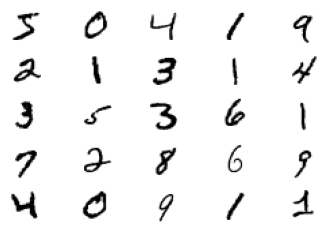

In [2]:
# example of loading the mnist dataset
from keras.datasets.mnist import load_data
from matplotlib import pyplot
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()
# plot images from the training dataset
for i in range(25):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis
	pyplot.axis('off')
	# plot raw pixel data
	pyplot.imshow(trainX[i], cmap='gray_r')
pyplot.show()

#2.. How to Define and Train the Discriminator Mode ($D$)

The first step is to define the discriminator model.

The model must take a sample image from our dataset as input and output a classification prediction as to whether the sample is real or fake. This is a binary classification problem:

* **Inputs**: Image with one channel and $28×28$ pixels in size.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

The discriminator model has two [convolutional layers](https://machinelearningmastery.com/convolutional-layers-for-deep-learning-neural-networks/) with $64$ filters each, a small kernel size of $3$, and larger than normal stride of $2$. The model has no pooling layers and a single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. The model is trained to minimize the [binary cross entropy loss function](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of **LeakyReLU** instead of [ReLU](https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/), using [Dropout](https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/), and using the [Adam version of stochastic gradient descent](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with a learning rate of 0.0002 and a momentum of 0.5.

The function **```define_discriminator()```** below defines the discriminator model and parametrizes the size of the input image.
```
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
```

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 64)          0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 flatten (Flatten)           (None, 3136)              0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


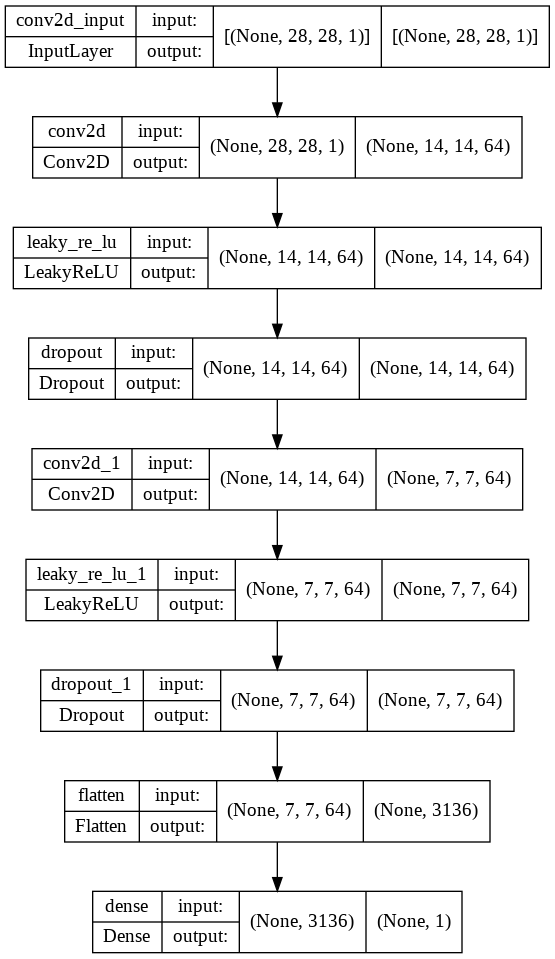

In [3]:
# example of defining the discriminator model
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define model
model = define_discriminator()
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

We could start training this model now with real examples with a class label of  '$1$', and randomly generated samples with a class label of  '$0$'.

The development of these elements will be useful later, and it helps to see that the discriminator is just a normal neural network model for binary classification.

First, we need a function to load and prepare the dataset of real images.

We will use the **```mnist.load_data()```** function to load the MNIST dataset and just use the input part of the training dataset as the real images.
```
# load mnist dataset
(trainX, _), (_, _) = load_data()
```

The images are 2D arrays of pixels and convolutional neural networks expect 3D arrays of images as input, where each image has one or more channels.

We must update the images to have an additional dimension for the grayscale channel. We can do this using the [```expand_dims() NumPy function```](https://docs.scipy.org/doc/numpy/reference/generated/numpy.expand_dims.html) and specify the final dimension for the channels-last image format.
```
# expand to 3d, e.g. add channels dimension
X = expand_dims(trainX, axis=-1)
```

Finally, we must scale the pixel values from the range of unsigned integers in $[0,255]$ to the normalized range of $[0,1]$.
```
# convert from unsigned ints to floats
X = X.astype('float32')
# scale from [0,255] to [0,1]
X = X / 255.0
```

The **```load_real_samples()```** function below implements this.

In [4]:
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

The model will be updated in batches, specifically with a collection of real samples and a collection of generated samples. On training, **epoch** is defined as one pass through the entire training dataset.

We could systematically enumerate all samples in the training dataset, and that is a good approach, but good training via stochastic gradient descent requires that the training dataset be shuffled prior to each epoch. A simpler approach is to select random samples of images from the training dataset.

The **```generate_real_samples()```** function below will take the training dataset as an argument and will select a random subsample of images; it will also return class labels for the sample, specifically a class label of $1$, to indicate real images.

In [5]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

Now, we need a source of fake images.

We don’t have a generator model yet, so instead, we can generate images comprised of random pixel values, specifically [random pixel values](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/) in the range $[0,1]$ like our scaled real images.

The **```generate_fake_samples()```** function below implements this behavior and generates images of random pixel values and their associated class label of 0, for fake.

In [6]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

Finally, we need to train the discriminator model.

This involves repeatedly retrieving samples of real images and samples of generated images and updating the model for a fixed number of iterations.

We will ignore the idea of epochs for now (e.g. complete passes through the training dataset) and fit the discriminator model for a fixed number of batches. The model will learn to discriminate between real and fake (randomly generated) images rapidly, therefore, not many batches will be required before it learns to discriminate perfectly.

The **```train_discriminator()```** function implements this, using a batch size of 256 images where $128$ are real and $128$ are fake each iteration.

We update the discriminator separately for real and fake examples so that we can calculate the accuracy of the model on each sample prior to the update. This gives insight into how the discriminator model is performing over time.

```
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)

		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))
```

Tying all of this together, the complete example of training an instance of the discriminator model on real and randomly generated (fake) images is listed below.

In [7]:
# example of training the discriminator model on real and random mnist images
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X

# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

# generate n fake samples with class labels
def generate_fake_samples(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(28 * 28 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 28, 28, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=256):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


>1 real=38% fake=9%
>2 real=55% fake=22%
>3 real=52% fake=48%
>4 real=58% fake=49%
>5 real=63% fake=72%
>6 real=62% fake=89%
>7 real=60% fake=95%
>8 real=62% fake=98%
>9 real=66% fake=99%
>10 real=67% fake=100%
>11 real=71% fake=100%
>12 real=70% fake=100%
>13 real=65% fake=100%
>14 real=73% fake=100%
>15 real=73% fake=100%
>16 real=79% fake=100%
>17 real=80% fake=100%
>18 real=82% fake=100%
>19 real=84% fake=100%
>20 real=82% fake=100%
>21 real=79% fake=100%
>22 real=85% fake=100%
>23 real=91% fake=100%
>24 real=92% fake=100%
>25 real=90% fake=100%
>26 real=95% fake=100%
>27 real=97% fake=100%
>28 real=95% fake=100%
>29 real=95% fake=100%
>30 real=97% fake=100%
>31 real=100% fake=100%
>32 real=98% fake=100%
>33 real=100% fake=100%
>34 real=100% fake=100%
>35 real=98% fake=100%
>36 real=99% fake=100%
>37 real=100% fake=100%
>38 real=100% fake=100%
>39 real=100% fake=100%
>40 real=100% fake=100%
>41 real=100% fake=100%
>42 real=100% fake=100%
>43 real=100% fake=100%
>44 real=100% fake=1

#3.. How to Define and Use the Generator Model ($G$)

The generator model is responsible for creating new, fake but plausible images of handwritten digits.

It does this by taking a point from the latent space as input and outputting a square grayscale image.

The latent space is an arbitrarily defined vector space of [Gaussian-distributed values](https://machinelearningmastery.com/statistical-data-distributions/), e.g. $100$ dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, MNIST images, that only the generator knows how to turn into plausible MNIST images.

* **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Outputs**: Two-dimensional square grayscale image of 28×28 pixels with pixel values in $[0,1]$.

Note: we don’t have to use a 100 element vector as input; it is a round number and widely used, but I would expect that 10, 50, or 500 would work just as well.

Developing a generator model requires that we transform a vector from the latent space with, $100$ dimensions to a 2D array with $28×28$ or $784$ values.

* There are a number of ways to achieve this but there is one approach that has proven effective at deep convolutional generative adversarial networks. It involves two main elements.
* The first is a Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be $14×14$ or $196$ nodes, and an image one quarter the size (one eighth the area) would be $7×7$ or $49$ nodes.

* We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a [pattern in convolutional neural networks](https://machinelearningmastery.com/review-of-architectural-innovations-for-convolutional-neural-networks-for-image-classification/) where we have many parallel filters resulting in multiple parallel activation maps, called **feature maps**, with different interpretations of the input. 
* We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

Therefore:
* the first hidden layer, the Dense, needs enough nodes for multiple low-resolution versions of our output image, such as 128.  
* The activations from these nodes can then be reshaped into something image-like to pass into a convolutional layer, such as 128 different 7×7 feature maps.
```
# foundation for 7x7 image
model.add(Dense(128 * 7 * 7, input_dim=100))
model.add(Reshape((7, 7, 128)))
```


The next major architectural innovation involves upsampling the low-resolution image to a higher resolution version of the image.

There are two common ways to do this upsampling process, sometimes called deconvolution.

1. One way is to use an ***UpSampling2D*** layer (like a reverse pooling layer) followed by a normal Conv2D layer. 
2. The other and perhaps more modern way is to combine these two operations into a single layer, called a ***Conv2DTranspose***. We will use this latter approach for our generator.

The ***Conv2DTranspose*** layer can be configured with a stride of $(2×2)$ that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to [avoid a checkerboard pattern](https://distill.pub/2016/deconv-checkerboard/) that can be observed when upsampling.
```
# upsample to 14x14
model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
```

This can be repeated to arrive at our $28×28$ output image.

Again, we will use the ***LeakyReLU*** with a default slope of $0.2$, reported as a best practice when training GAN models.

The output layer of the model is a ***Conv2D*** with one filter and a kernel size of $7×7$ and [‘same’ padding](https://machinelearningmastery.com/padding-and-stride-for-convolutional-neural-networks/), designed to create a single feature map and preserve its dimensions at $28×28$ pixels. A sigmoid activation is used to ensure output values are in the desired range of $[0,1]$.

The **```define_generator()```** function below implements this and defines the generator model.
```
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	
  # upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	
  # upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))

	return model
```

The complete example is listed below.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 6272)              633472    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 6272)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 128)      262272    
 nspose)                                                         
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 14, 14, 128)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 128)      262272    
 ranspose)                                            

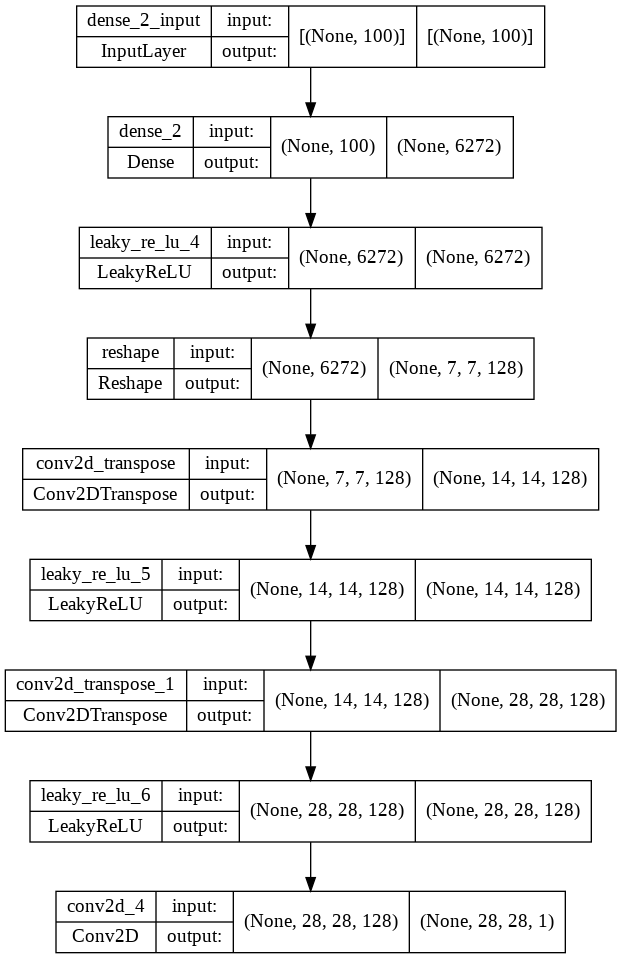

In [8]:
# example of defining the generator model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.utils.vis_utils import plot_model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the size of the latent space
latent_dim = 100
# define the generator model
model = define_generator(latent_dim)
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

This model cannot do much at the moment.

Nevertheless, we can demonstrate how to use it to generate samples. This is a helpful demonstration to understand the generator as just another model, and some of these elements will be useful later.

The first step is to generate new points in the latent space. We can achieve this by calling the [randn() NumPy function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.randn.html) for generating arrays of [random numbers drawn from a standard Gaussian](https://machinelearningmastery.com/how-to-generate-random-numbers-in-python/).

The array of random numbers can then be reshaped into samples, that is $n$ rows with $100$ elements per row. The **```generate_latent_points()```** function below implements this and generates the desired number of points in the latent space that can be used as input to the generator model.

In [9]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

Next, we can use the generated points as input to the generator model to generate new samples, then plot the samples.

We can update the **```generate_fake_samples()```** function from the previous section to take the generator model as an argument and use it to generate the desired number of samples by first calling the **```generate_latent_points()```** function to generate the required number of points in latent space as input to the model.

The updated **```generate_fake_samples()```** function is listed below and returns both the generated samples and the associated class labels.

In [10]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

We can then plot the generated samples as we did the real MNIST examples in the first section by calling the **```imshow()```** function with the reversed grayscale color map.

The complete example of generating new MNIST images with the untrained generator model is listed below.

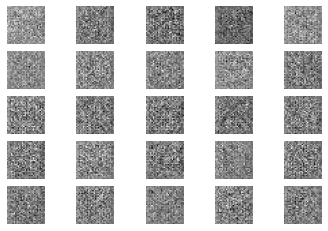

In [11]:
# example of defining and using the generator model
from numpy import zeros
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from matplotlib import pyplot

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

# size of the latent space
latent_dim = 100
# define the discriminator model
model = define_generator(latent_dim)
# generate samples
n_samples = 25
X, _ = generate_fake_samples(model, latent_dim, n_samples)
# plot the generated samples
for i in range(n_samples):
	# define subplot
	pyplot.subplot(5, 5, 1 + i)
	# turn off axis labels
	pyplot.axis('off')
	# plot single image
	pyplot.imshow(X[i, :, :, 0], cmap='gray_r')
# show the figure
pyplot.show()

#4.. Training the Generator Model ($G$)

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the **zero-sum** or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

Specifically, a new GAN model can be defined that stacks the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

* Only the **discriminator** is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a standalone manner on examples of each, as we did in the section on the discriminator model above.

* The **generator** model is only concerned with the discriminator’s performance on fake examples. 
  - Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. 
* We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class $1$).

**Why would we want to do this?**

We can imagine that the discriminator will then classify the generated samples as not real (class $0$) or a low probability of being real (0.3 or 0.5). The backpropagation process used to update the model weights will see this as a large error and will update the model weights (i.e. only the weights in the generator) to correct for this error, in turn making the generator better at generating good fake samples.

Let’s make this concrete.

* **Inputs**: Point in latent space, e.g. a 100 element vector of Gaussian random numbers.
* **Outputs**: Binary classification, likelihood the sample is real (or fake).

The **```define_gan()```** function below takes as arguments the already-defined generator and discriminator models and creates the new logical third model subsuming these two models. The weights in the discriminator are marked as not trainable, which only affects the weights as seen by the GAN model and not the standalone discriminator model.

In [12]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

Making the discriminator not trainable is a clever trick in the Keras API.

1. The **trainable property** impacts the model after it is compiled. The discriminator model was compiled with trainable layers, therefore the model weights in those layers will be updated when the **standalone model** is updated via calls to the **```train_on_batch()```** function.

2. The discriminator model was then marked as **not trainable**, added to the GAN model, and compiled. In this model, the model weights of the discriminator model are not trainable and cannot be changed when the GAN model is updated via calls to the **```train_on_batch()```** function. **This change in the trainable property does not impact the training of standalone discriminator model.**

This behavior is described in the Keras API documentation here:

  - [How can I “freeze” Keras layers?](https://keras.io/getting-started/faq/#how-can-i-freeze-keras-layers)
  
The complete example of creating the discriminator, generator, and composite model is listed below.

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_8 (Sequential)   (None, 28, 28, 1)         1164289   


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


                                                                 
 sequential_7 (Sequential)   (None, 1)                 40705     
                                                                 
Total params: 1,204,994
Trainable params: 1,164,289
Non-trainable params: 40,705
_________________________________________________________________


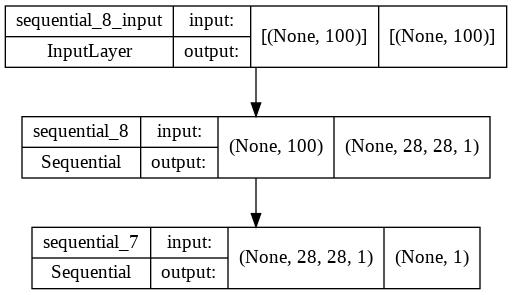

In [16]:
# demonstrate creating the three models in the gan
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Dropout
from keras.utils.vis_utils import plot_model

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

Training the composite model involves generating a batch worth of points in the latent space via the **```generate_latent_points()```** function in the previous section, and class=$1$ labels and calling the **```train_on_batch()```** function.

The **```train_gan()```** function below demonstrates this, although is pretty simple as only the generator will be updated each epoch, leaving the discriminator with default model weights.

In [17]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=100, n_batch=256):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

**Instead, what is required is that we first update the discriminator model with real and fake samples, then update the generator via the composite model.**

This requires combining elements from the **```train_discriminator()```** function defined in the discriminator section above and the **```train_gan()```** function defined above. It also requires that we enumerate over both epochs and batches within in an epoch.

The complete train function for updating the discriminator model and the generator (via the composite model) is listed below.

There are a few things to note in this model training function.

1. First, the number of batches within an epoch is defined by how many times the batch size divides into the training dataset. We have a dataset size of 60K samples, so with rounding down, there are 234 batches per epoch.

2. The discriminator model is updated once per batch by combining one half a batch of fake and real examples into a single batch via the [vstack() NumPy function](https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html). 
  - You could update the discriminator with each half batch separately (recommended for more complex datasets) 
  - but combining the samples into a single batch will be faster over a long run, especially when training on GPU hardware.

Finally, we report the loss each batch. It is critical to keep an eye on the loss over batches. The reason for this is that 
  - a crash in the discriminator loss indicates that the generator model has started generating rubbish examples that the discriminator can easily discriminate.

* Monitor the **discriminator** loss and expect it to hover around $0.5$ to $0.8$ per batch on this dataset. 
* The generator loss is less critical and may hover between 0.5 and 2 or higher on this dataset. A clever programmer might even attempt to detect the crashing loss of the discriminator, halt, and then restart the training process.

In [18]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))

#5.. Evaluate GAN Model Performance

#6..Use the Final Generator Model to Generate Images